# Time Series

## Introduction

This analysis focused on whether inflation in USA can be used to model inflation in the Euro area. Inflation was measured by consumer price index (CPI).

The data was obtained from the Reserve Bank of Australia and included observations from the beginning of 2000 to the end of 2011.

Data from 2000 to 2010 was used to model the trends, while data from 2011 was used for forecasting.

In [1]:
# loads packages

library(data.table)
library(ggplot2)
library(magrittr)
library(tseries)
library(dLagM)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: nardl

Loading required package: dynlm

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [2]:
# sets ggplot2 style

theme_set(theme_bw() + theme(panel.border=element_blank(), panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.line=element_line(colour="black")))

In [3]:
# loads data set

dat_inflation<-fread("Data/Data_Inflation.csv")

setnames(dat_inflation, "YYYY-MM", "date") # changes the name of the date column for convenience's sake

dat_inflation_2000_2010<-dat_inflation[1:132]

dat_inflation_2010_2011<-dat_inflation[120:144]

## Data Visualisation

I first looked at $\mathit{CPI}$ and transformed it when non-stationarity was clearly violated.

In [4]:
# prepares data for plotting

dat_inflation_plt_CPI<-melt(dat_inflation_2000_2010, id.vars=c("date"), measure.vars=c("CPI_EUR", "CPI_USA"), variable.name="region", value.name="CPI")

dat_inflation_plt_CPI[region=="CPI_EUR", region:="Euro Area"][region=="CPI_USA", region:="USA"]

In [5]:
array_date_CPI<-c("2000M01", "2004M01", "2008M01", "2011M12") # creates labels for x-axis tick marks

plt_CPI<-ggplot(dat_inflation_plt_CPI) +
  aes(y=CPI, x=date, group=region, linetype=region) +
  geom_line() +
  scale_x_discrete(breaks=array_date_CPI) +
  ggtitle("Figure 1. CPI 2000-2010.") + 
  labs(y="CPI", x="Date", linetype="Region")

Time series of both regions' $\mathit{CPI}$ are shown below in Figure 1, which suggests that the two regions had similar trends in inflation with the USA having higher values in consumer price. Both series had been increasing over time, with the USA having a noticeable drop around late 2008.

Neither of the trends seems stationary.

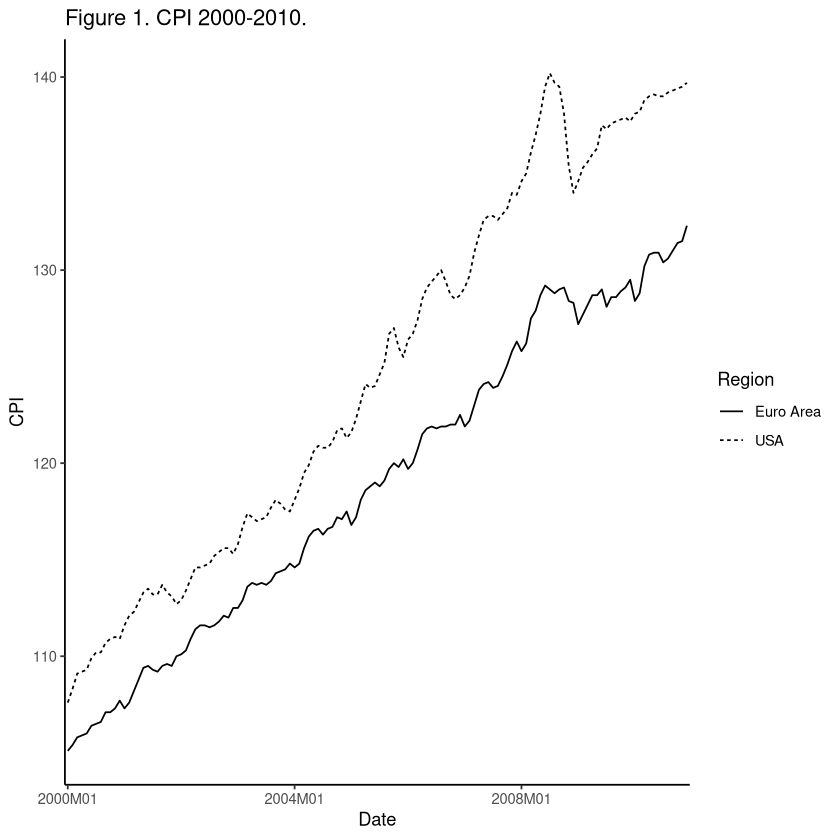

In [6]:
plt_CPI

In [7]:
dat_inflation_2000_2010[, ":="(log_CPI_EUR=log(CPI_EUR), log_CPI_USA=log(CPI_USA))] # creates log(CPI)

dat_inflation_plt_log_CPI<-melt(dat_inflation_2000_2010, id.vars=c("date"), measure.vars=c("log_CPI_EUR", "log_CPI_USA"), variable.name="region", value.name="log_CPI")

dat_inflation_plt_log_CPI[region=="log_CPI_EUR", region:="Euro Area"][region=="log_CPI_USA", region:="USA"]

In [8]:
plt_log_CPI<-ggplot(dat_inflation_plt_log_CPI) +
  aes(y=log_CPI, x=date, group=region, linetype=region) +
  geom_line() +
  scale_x_discrete(breaks=array_date_CPI) +
  ggtitle("Figure 2. log(CPI) 2000-2010.") + 
  labs(y="log(CPI)", x="Date", linetype="Region")

As shown in Figure 2, $\log(\mathit{CPI})$ shows similar trends to $\mathit{CPI}$.

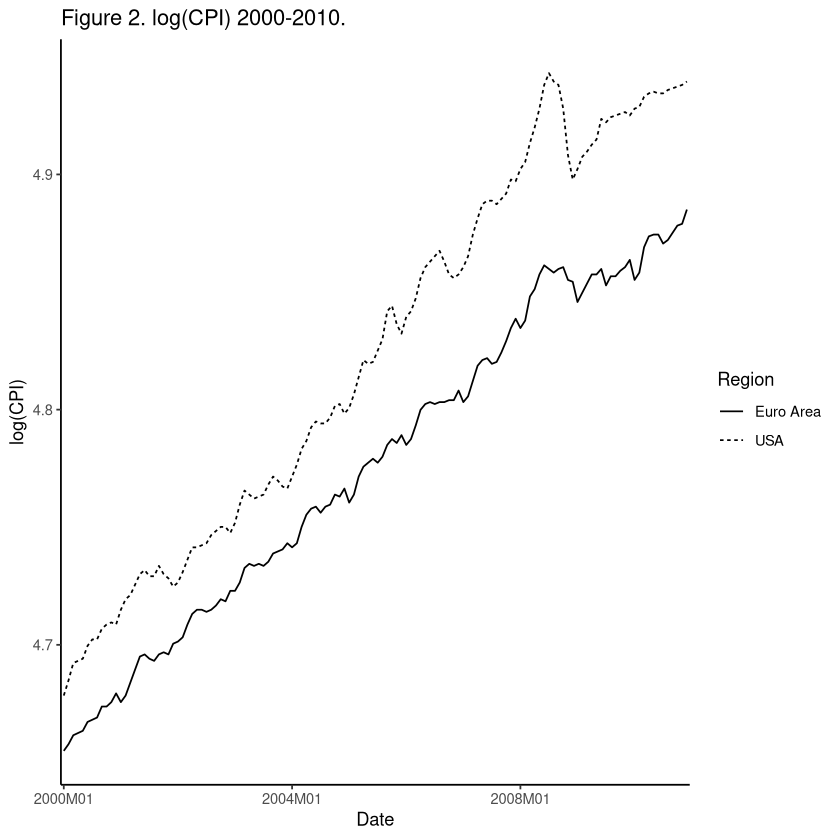

In [9]:
plt_log_CPI

In [10]:
# creates delta log(CPI)

delta_log_CPI_EUR_2000_2010<-diff(dat_inflation_2000_2010$log_CPI_EUR)
delta_log_CPI_USA_2000_2010<-diff(dat_inflation_2000_2010$log_CPI_USA)

dat_inflation_2000_2010[, ":="(delta_log_CPI_EUR=c(NA, delta_log_CPI_EUR_2000_2010), delta_log_CPI_USA=c(NA, delta_log_CPI_USA_2000_2010))] # values at the first time point are NA since the difference values do not exist

In [11]:
dat_inflation_plt_delta_log_CPI<-melt(dat_inflation_2000_2010, id.vars=c("date"), measure.vars=c("delta_log_CPI_EUR", "delta_log_CPI_USA"), variable.name="region", value.name="delta_log_CPI")

dat_inflation_plt_delta_log_CPI[region=="delta_log_CPI_EUR", region:="Euro Area"][region=="delta_log_CPI_USA", region:="USA"]

In [12]:
plt_delta_log_CPI<-ggplot(dat_inflation_plt_delta_log_CPI[!is.na(delta_log_CPI)]) + # excludes values from the first time point since the difference values do not exist
  aes(y=delta_log_CPI, x=date, group=region, linetype=region) +
  geom_line() +
  scale_x_discrete(breaks=array_date_CPI) +
  ggtitle("Figure 2. delta log(CPI) 2000-2010.") + 
  labs(y="delta log(CPI)", x="Date", linetype="Region")

$\Delta \log(\mathit{CPI})$ is the two-month difference in $log(\mathit{CPI})$.

$\Delta \log(\mathit{CPI})$ of the two regions is shown below in Figure 3. Consistent with the two earlier plots, the USA saw a larger drop in late 2008.

Importantly, $\Delta \log(\mathit{CPI})$ seems stationary.

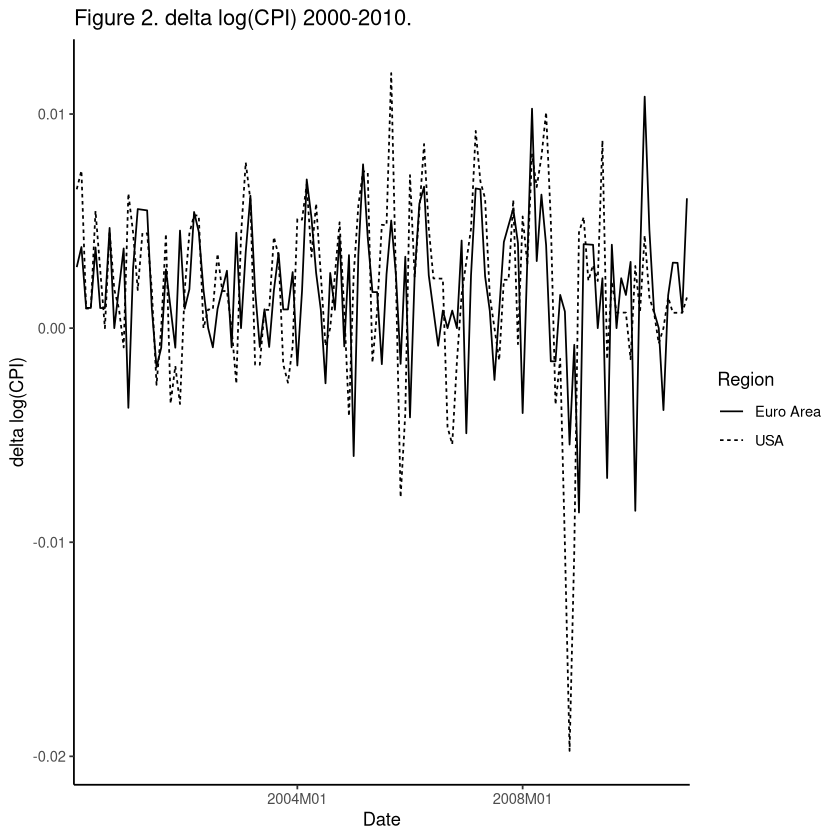

In [13]:
plt_delta_log_CPI

### Stationarity Tests

Below, Augmented Dickey-Fuller (ADF) tests show that non-stationarity was rejected for $\Delta \log(\mathit{CPI})$ of both regions, therefore there is no clear trend direction.

In [14]:
adf.test(delta_log_CPI_EUR_2000_2010, "stationary", k=10)

Warning message in adf.test(delta_log_CPI_EUR_2000_2010, "stationary", k = 10):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  delta_log_CPI_EUR_2000_2010
Dickey-Fuller = -4.1224, Lag order = 10, p-value = 0.01
alternative hypothesis: stationary


In [15]:
adf.test(delta_log_CPI_USA_2000_2010, "stationary", k=10)


	Augmented Dickey-Fuller Test

data:  delta_log_CPI_USA_2000_2010
Dickey-Fuller = -3.504, Lag order = 10, p-value = 0.04475
alternative hypothesis: stationary


### Autocorrelations

Since I was interested in modelling $\Delta \log(\mathit{CPI})_{\mathit{Euro}}$ with that $\Delta \log(\mathit{CPI})_{\mathit{USA}}$, I looked at partial autocorrelations in the Euro region and autocorrelations in the USA.

Partial autocorrelations of $\Delta \log(\mathit{CPI})_{\mathit{Euro}}$ showed two major spikes, at lags 6 and 12, with a few smaller spikes.

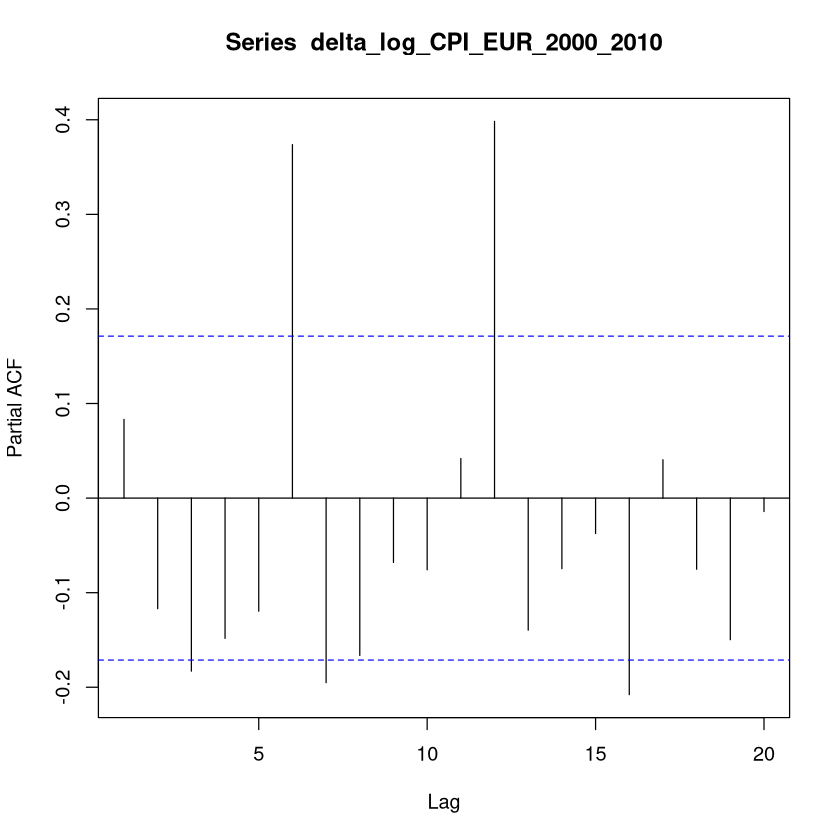

In [16]:
acf(delta_log_CPI_EUR_2000_2010, lag.max=20, type="partial", plot=TRUE)

This was naturally supported by the results of Ljung-Box test.

In [17]:
Box.test(delta_log_CPI_EUR_2000_2010, lag=6)


	Box-Pierce test

data:  delta_log_CPI_EUR_2000_2010
X-squared = 33.263, df = 6, p-value = 9.332e-06


Autocorrelations of the $\Delta \log(\mathit{CPI})_{\mathit{USA}}$ showed a number of spikes between lags 5 to 12.

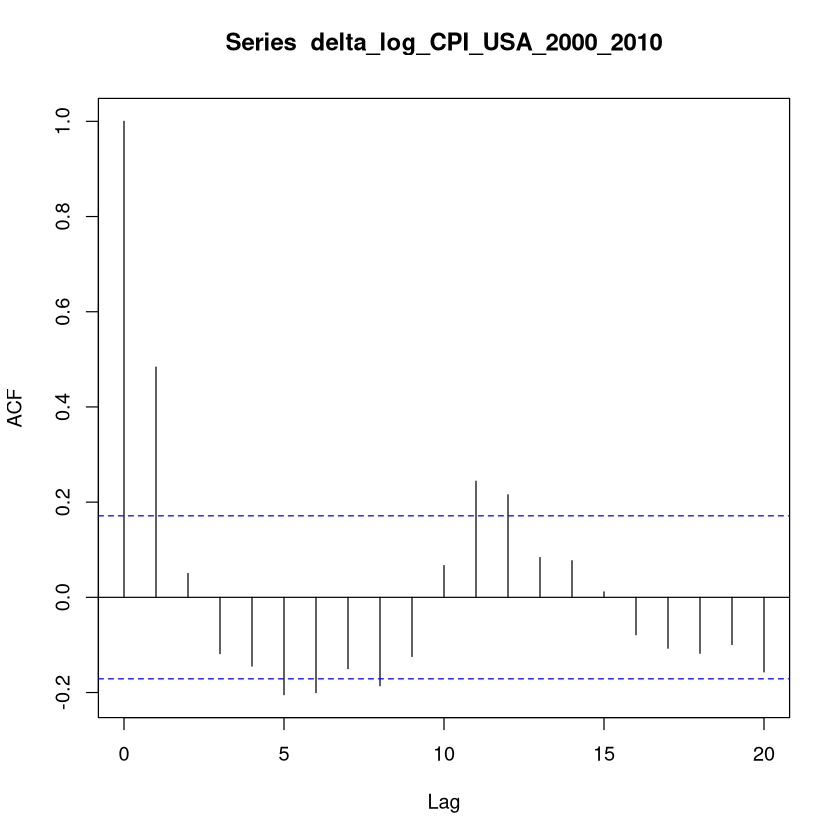

In [18]:
acf(delta_log_CPI_USA_2000_2010, lag.max=20, type="correlation", plot=TRUE)

The above results suggested that a AR model with $\Delta \log(\mathit{CPI})_{\mathit{Euro}}$ with lags 6 and 12 might be appropriate. Lags for $\Delta \log(\mathit{CPI})_{\mathit{USA}}$ allowed certain degree of flexibility.

## Models

### Autogressive (AR) Model

An AR model with lags 6 and 12 was first tested:

$$
\Delta \log(\mathit{CPI})\mathit{Euro}_{t} = \alpha + \beta_1 \Delta \log(\mathit{CPI})\mathit{Euro}_{t-6} + \beta_2 \Delta \log(\mathit{CPI})\mathit{Euro}_{t-12} + \varepsilon_t
$$

Results showed that both $\Delta \log(\mathit{CPI})\mathit{Euro}_{t-6}$ and $\Delta \log(\mathit{CPI})\mathit{Euro}_{t-12}$ were significant.

In [19]:
ar_delta_log_CPI_EUR<-arma(delta_log_CPI_EUR_2000_2010, lag=list(ar=c(6, 12)), include.intercept=TRUE)

Warning message in arma(delta_log_CPI_EUR_2000_2010, lag = list(ar = c(6, 12)), :
“order is ignored”


In [20]:
summary(ar_delta_log_CPI_EUR)


Call:
arma(x = delta_log_CPI_EUR_2000_2010, lag = list(ar = c(6, 12)),     include.intercept = TRUE)

Model:
ARMA(12,0)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.033e-02 -1.737e-03 -4.734e-05  1.532e-03  8.091e-03 

Coefficient(s):
           Estimate  Std. Error  t value Pr(>|t|)    
ar6       0.1887418   0.0727295    2.595  0.00946 ** 
ar12      0.5979143   0.0786256    7.605 2.86e-14 ***
intercept 0.0003838   0.0002646    1.451  0.14689    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Fit:
sigma^2 estimated as 6.486e-06,  Conditional Sum-of-Squares = 0,  AIC = -1187.15


### Autoregressive Distributed Lag (ADL) Model

An ADL model was used to include certain lags in $\Delta \log(\mathit{CPI})_{\mathit{USA}}$:

$$
\Delta \log(\mathit{CPI})\mathit{Euro}_{t}  = \alpha + \beta_1 \Delta \log(\mathit{CPI})\mathit{Euro}_{t-6}  + \beta_2 \Delta \log(\mathit{CPI})\mathit{Euro}_{t-12}  + \gamma_1 \Delta \log(\mathit{CPI})\mathit{USA}_{t-1}  + \gamma_2 \Delta \log(\mathit{CPI})\mathit{USA}_{t-6} + \gamma_3 \Delta \log(\mathit{CPI})\mathit{USA}_{t-12} + \varepsilon_t
$$

Results showed that $\Delta \log(\mathit{CPI})\mathit{USA}_{t-6}$ is not significant.

In [21]:
adl_delta_log_CPI_EUR_USA_1<-ardlDlm(y=delta_log_CPI_EUR_2000_2010, x=delta_log_CPI_USA_2000_2010, p=12, q=12, remove=list(q=c(1:5, 7:11), p=c(0, 2:5, 7:11))) # q for y, p for x

In [22]:
summary(adl_delta_log_CPI_EUR_USA_1)


Time series regression with "ts" data:
Start = 13, End = 131

Call:
dynlm(formula = as.formula(model.text), data = data, start = 1)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0065866 -0.0016535 -0.0000117  0.0012633  0.0082683 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0004407  0.0002853   1.545    0.125    
X.1          0.2264303  0.0511299   4.429 2.20e-05 ***
X.6         -0.0560495  0.0547668  -1.023    0.308    
X.12        -0.2300590  0.0541714  -4.247 4.47e-05 ***
Y.6          0.2029831  0.0785535   2.584    0.011 *  
Y.12         0.6367563  0.0874784   7.279 4.78e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.002272 on 113 degrees of freedom
Multiple R-squared:  0.5602,	Adjusted R-squared:  0.5408 
F-statistic: 28.79 on 5 and 113 DF,  p-value: < 2.2e-16



A second model was tested with $\Delta \log(\mathit{CPI})\mathit{USA}_{t-6}$ removed:

$$
\Delta \log(\mathit{CPI})\mathit{Euro}_{t}  = \alpha + \beta_1 \Delta \log(\mathit{CPI})\mathit{Euro}_{t-6}  + \beta_2 \Delta \log(\mathit{CPI})\mathit{Euro}_{t-12}  + \gamma_1 \Delta \log(\mathit{CPI})\mathit{USA}_{t-1}  + \gamma_3 \Delta \log(\mathit{CPI})\mathit{USA}_{t-12} + \varepsilon_t
$$

All predictors are significant in this model.

In [23]:
adl_delta_log_CPI_EUR_USA_2<-ardlDlm(y=delta_log_CPI_EUR_2000_2010, x=delta_log_CPI_USA_2000_2010, p=12, q=12, remove=list(q=c(1:5, 7:11), p=c(0, 2:11)))

In [24]:
coef_adl_delta_log_CPI_EUR_USA_2<-as.data.frame(summary(adl_delta_log_CPI_EUR_USA_2)$coef) # saves the coefficients for forecasting


Time series regression with "ts" data:
Start = 13, End = 131

Call:
dynlm(formula = as.formula(model.text), data = data, start = 1)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0067809 -0.0016353  0.0000532  0.0013660  0.0082449 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0003391  0.0002676   1.267   0.2076    
X.1          0.2326463  0.0507784   4.582 1.19e-05 ***
X.12        -0.2265061  0.0540712  -4.189 5.55e-05 ***
Y.6          0.1687277  0.0710803   2.374   0.0193 *  
Y.12         0.6551636  0.0856272   7.651 6.93e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.002273 on 114 degrees of freedom
Multiple R-squared:  0.5561,	Adjusted R-squared:  0.5406 
F-statistic: 35.71 on 4 and 114 DF,  p-value: < 2.2e-16



## Forecasting

Two series of 12 monthly forecasts were created for $\Delta \log(\mathit{CPI})_{\mathit{Euro}}$ in 2011 using the models. That is, the value of each month was predicted by the 12 previous months.

Model errors were measured in root mean squared error (RMSE), mean absolute error (MAE), and the sum of the forecast errors (SUM).

Results showed that the ADL model provided better fit. This suggests that inflations in the USA could indeed predict inflations in the Euro region.

In [25]:
# extracts parameters from the AR model

m1_alpha<-summary(ar_delta_log_CPI_EUR)$coef[3, 1]
m1_beta_1<-summary(ar_delta_log_CPI_EUR)$coef[1, 1]
m1_beta_2<-summary(ar_delta_log_CPI_EUR)$coef[2, 1]

In [26]:
# extracts parameters from the ADL model

m2_alpha<-coef_adl_delta_log_CPI_EUR_USA_2[1, 1]
m2_beta_1<-coef_adl_delta_log_CPI_EUR_USA_2[4, 1]
m2_beta_2<-coef_adl_delta_log_CPI_EUR_USA_2[5, 1]
m2_gamma_1<-coef_adl_delta_log_CPI_EUR_USA_2[2, 1]
m2_gamma_3<-coef_adl_delta_log_CPI_EUR_USA_2[3, 1]

In [27]:
# prepares the data (log, delta log, predictions)

dat_inflation_2010_2011[, ":="(log_CPI_EUR=log(CPI_EUR), log_CPI_USA=log(CPI_USA))]

delta_log_CPI_EUR_2010_2011<-diff(dat_inflation_2010_2011$log_CPI_EUR)
delta_log_CPI_USA_2010_2011<-diff(dat_inflation_2010_2011$log_CPI_USA)

dat_inflation_2010_2011[, ":="(delta_log_CPI_EUR=c(NA, delta_log_CPI_EUR_2010_2011), delta_log_CPI_USA=c(NA, delta_log_CPI_USA_2010_2011))]

dat_inflation_2010_2011[, ":="(delta_log_CPI_EUR_predict_m1=numeric(0), delta_log_CPI_EUR_predict_m2=numeric(0))]

In [28]:
# the data set is small, so a for-loop is used here to manually create predictions

target_trend<-133:144

for (i in target_trend){
  
  dat_inflation_2010_2011[TREND==i, delta_log_CPI_EUR_predict_m1:=(m1_alpha + m1_beta_1 * dat_inflation_2010_2011[TREND==(i-6), delta_log_CPI_EUR] + m1_beta_2 * dat_inflation_2010_2011[TREND==(i-12), delta_log_CPI_EUR])]
    
    dat_inflation_2010_2011[TREND==i, delta_log_CPI_EUR_predict_m2:=(m2_alpha + m2_beta_1 * dat_inflation_2010_2011[TREND==(i-6), delta_log_CPI_EUR] + m2_beta_2 * dat_inflation_2010_2011[TREND==(i-12), delta_log_CPI_EUR] + m2_gamma_1 * dat_inflation_2010_2011[TREND==(i-1), delta_log_CPI_USA] + m2_gamma_3 * dat_inflation_2010_2011[TREND==(i-12), delta_log_CPI_USA])]
  
}

In [29]:
dat_inflation_2011<-dat_inflation_2010_2011[14:25]

dat_inflation_2011_plt<-melt(dat_inflation_2011, id.vars=c("date"), measure.vars=c("delta_log_CPI_EUR", "delta_log_CPI_EUR_predict_m1", "delta_log_CPI_EUR_predict_m2"), variable.name="source", value.name="delta_log_CPI_EUR")

dat_inflation_2011_plt[source=="delta_log_CPI_EUR", source:="Actual Data"][source=="delta_log_CPI_EUR_predict_m1", source:="AR Model"][source=="delta_log_CPI_EUR_predict_m2", source:="ADL Model"]

array_date_models<-c("2011M02", "2011M06", "2011M10")

plt_models<-ggplot(dat_inflation_2011_plt) +
  aes(y=delta_log_CPI_EUR, x=date, group=source, linetype=source) +
  geom_line() +
  scale_x_discrete(breaks=array_date_models) +
  ggtitle("Figure 4. Predictions of the AR and ADL Models.") + 
  labs(y="delta log(CPI)", x="Date", linetype="Source")

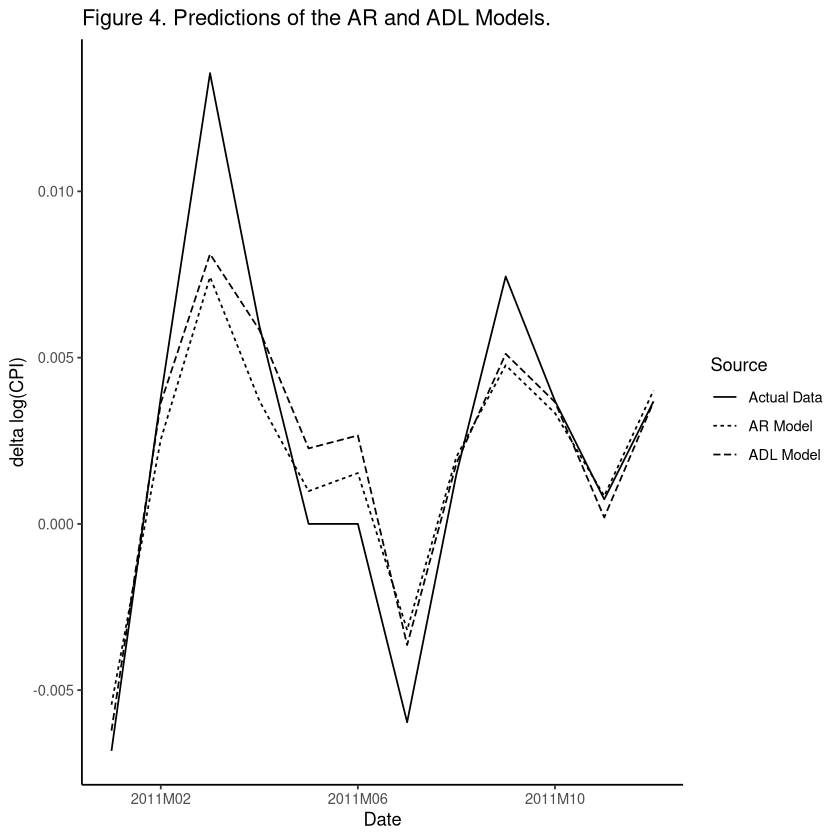

In [30]:
plt_models

In [31]:
# prediction errors of the AR model

RMSE_m1<-sum((dat_inflation_2011[, delta_log_CPI_EUR] - dat_inflation_2011[, delta_log_CPI_EUR_predict_m1])^2)/12 %>% sqrt

MAE_m1<-sum(abs(dat_inflation_2011[, delta_log_CPI_EUR] - dat_inflation_2011[, delta_log_CPI_EUR_predict_m1]))/12

SUM_m1<-sum(dat_inflation_2011[, delta_log_CPI_EUR] - dat_inflation_2011[, delta_log_CPI_EUR_predict_m1])

In [32]:
# prediction errors of the ADL model

RMSE_m2<-sum((dat_inflation_2011[, delta_log_CPI_EUR] - dat_inflation_2011[, delta_log_CPI_EUR_predict_m2])^2)/12 %>% sqrt

MAE_m2<-sum(abs(dat_inflation_2011[, delta_log_CPI_EUR] - dat_inflation_2011[, delta_log_CPI_EUR_predict_m2]))/12

SUM_m2<-sum(dat_inflation_2011[, delta_log_CPI_EUR] - dat_inflation_2011[, delta_log_CPI_EUR_predict_m2])

In [33]:
RMSE_m1
MAE_m1
SUM_m1

[1] 1.871708e-05

[1] 0.001692601

[1] 0.005066692

In [34]:
RMSE_m2
MAE_m2
SUM_m2

[1] 1.543021e-05

[1] 0.001403663

[1] 0.0004784685